**Setup & Install Library**

In [1]:
!pip install langchain_community replicate wordcloud seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.3 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
import replicate
import os, re, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from google.colab import userdata
api_token = userdata.get('api_token')
os.environ['REPLICATE_API_TOKEN'] = api_token

**Load & Preprocessing Data**

In [4]:
# Load file
wondr = pd.read_csv("/content/wondr-bni-review.csv")
bni = pd.read_csv("/content/bni-review.csv")

In [5]:
# Tambah Label Aplikasi
wondr['app'] = 'Wondr BNI'
bni['app'] = 'BNI Mobile'

In [6]:
# Gabungkan Data
df = pd.concat([wondr, bni], ignore_index=True)
df = df[['text', 'app']].dropna()

In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www.\S+", "", text)       # Hapus URL
    text = re.sub(r"[^a-zA-Z\s]", "", text)           # Hapus angka dan simbol
    text = re.sub(r"\s+", " ", text).strip()          # Normalisasi space
    return text

df['clean_text'] = df['text'].astype(str).apply(clean_text)
df = df[df['clean_text'].str.strip() != ""]

**Sentiment Classification Using Granite and LangChain**

In [8]:
def classify_sentiment(text):
    prompt = f"""
Tugas Anda adalah menentukan sentimen dari ulasan pengguna terhadap aplikasi.
Jawaban hanya boleh berupa salah satu dari tiga label berikut:
- Positif
- Negatif
- Netral

Ulasan:
\"{text}\"

Jawaban Anda (hanya satu kata: Positif / Negatif / Netral):
"""
    try:
        output = replicate.run(
            "ibm-granite/granite-3.3-8b-instruct",
            input={"prompt": prompt, "max_new_tokens": 20}
        )
        response = "".join(output)
        sentiment = re.search(r"(Positif|Negatif|Netral)", response, re.IGNORECASE)
        return sentiment.group(1).capitalize() if sentiment else "Tidak Terdeteksi"
    except:
        return "Tidak Terdeteksi"

In [9]:
# Proses
df['sentiment'] = df['clean_text'].apply(classify_sentiment)

In [10]:
df.to_csv("hasil_sentimen_semua.csv", index=False)

**Sentiment Visualization per App**

In [11]:
#Ringkasan Sentimen per Aplikasi
sentimen_summary = df.groupby(['app', 'sentiment']).size().unstack().fillna(0)
sentimen_summary['Total'] = sentimen_summary.sum(axis=1)
sentimen_summary['% Positif'] = (sentimen_summary['Positif'] / sentimen_summary['Total']) * 100
sentimen_summary['% Negatif'] = (sentimen_summary['Negatif'] / sentimen_summary['Total']) * 100
sentimen_summary['% Netral'] = (sentimen_summary['Netral'] / sentimen_summary['Total']) * 100

sentimen_summary

sentiment,Negatif,Netral,Positif,Tidak Terdeteksi,Total,% Positif,% Negatif,% Netral
app,,,,,,,,
BNI Mobile,2811.0,12.0,176.0,1.0,3000.0,5.866667,93.70000,0.400000
Wondr BNI,2066.0,20.0,913.0,0.0,2999.0,30.443481,68.88963,0.666889


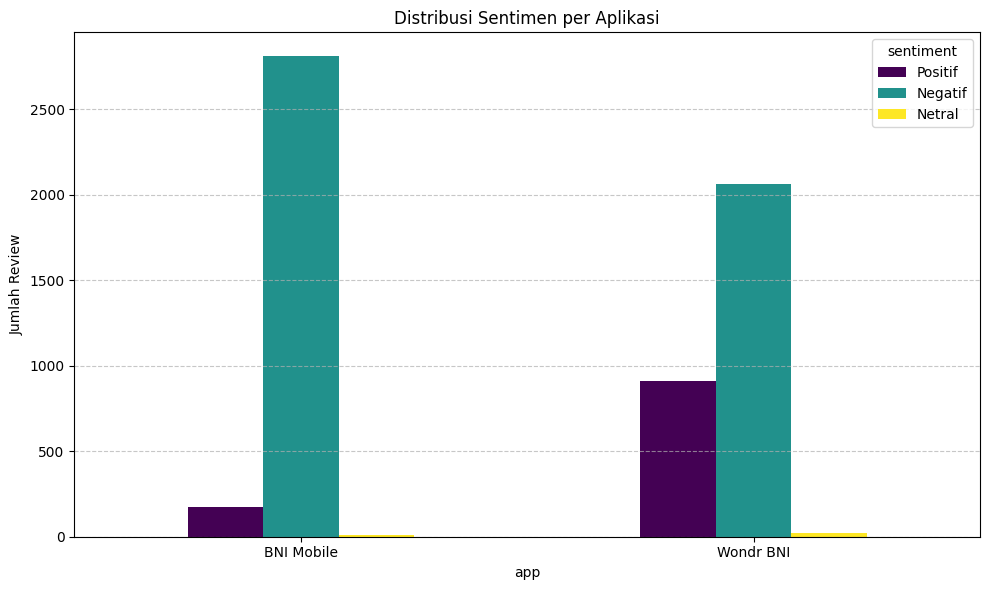

In [12]:
#Visualisasi: Bar Chart Perbandingan Sentimen
import matplotlib.pyplot as plt

sentimen_summary[['Positif', 'Negatif', 'Netral']].plot(kind='bar', figsize=(10,6), colormap='viridis')
plt.title("Distribusi Sentimen per Aplikasi")
plt.ylabel("Jumlah Review")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**WordCloud per Sentiment and Application**

In [13]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Stopwords dari NLTK + tambahan kustom
custom_stopwords = {
    'yg', 'nya', 'aja', 'udah', 'tp', 'kalo', 'dll', 'banget',
    'sy', 'biar', 'dong', 'sm', 'sih', 'ga', 'tdk', 'ok', 'oke', 'kayak', 'makasih'
}

stop_words = set(stopwords.words('indonesian')).union(custom_stopwords)

# Fungsi penghapus stopwords gabungan
def remove_stopwords(text):
    words = text.split()
    filtered = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered)

# Kolom untuk WordCloud saja, tidak dipakai klasifikasi
df['text_no_stopwords'] = df['clean_text'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
from wordcloud import WordCloud

def show_wordcloud(data, title):
    text = " ".join(data)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()


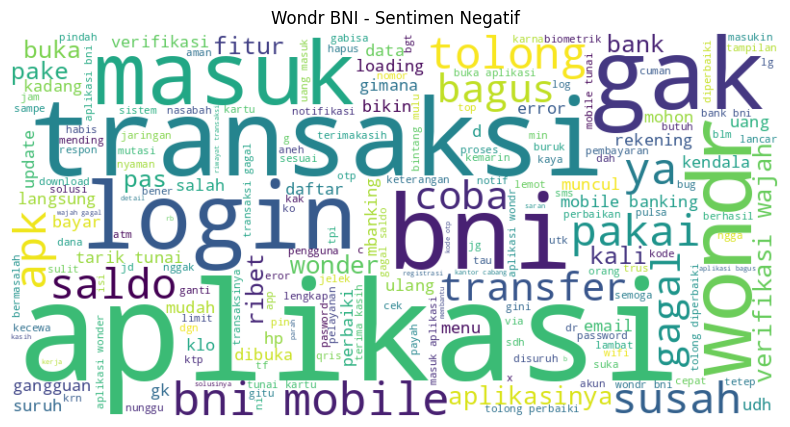

In [15]:
# WordCloud untuk review negatif di Wondr
show_wordcloud(df[(df['app']=='Wondr BNI') & (df['sentiment']=='Negatif')]['text_no_stopwords'], "Wondr BNI - Sentimen Negatif")

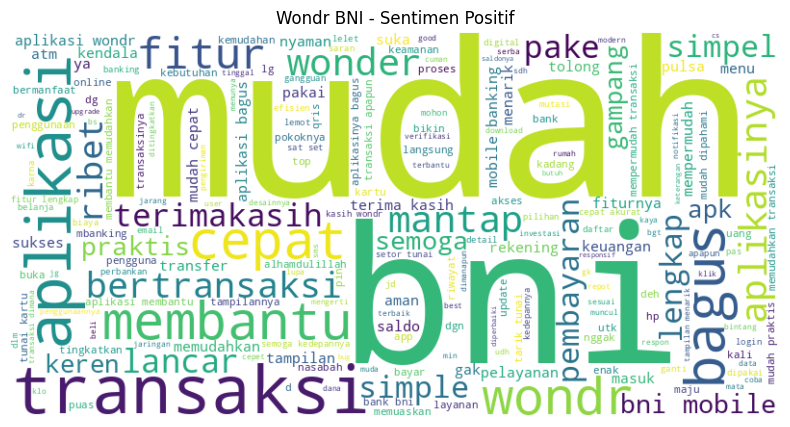

In [16]:
# WordCloud untuk review positif di Wondr
show_wordcloud(df[(df['app']=='Wondr BNI') & (df['sentiment']=='Positif')]['text_no_stopwords'], "Wondr BNI - Sentimen Positif")

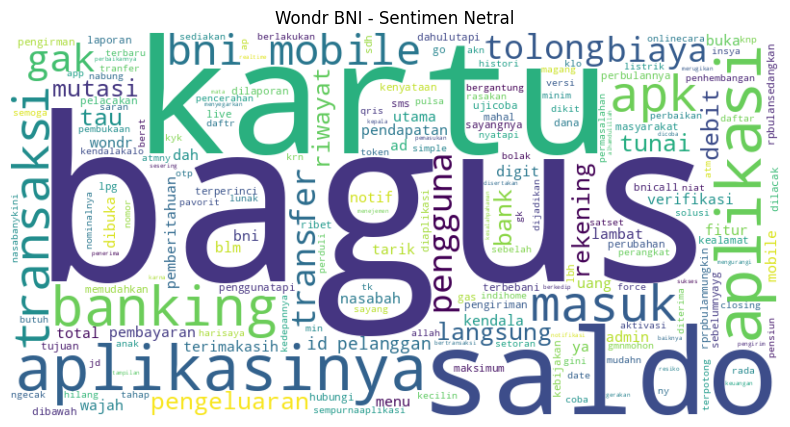

In [17]:
# WordCloud untuk review Netral di Wondr
show_wordcloud(df[(df['app']=='Wondr BNI') & (df['sentiment']=='Netral')]['text_no_stopwords'], "Wondr BNI - Sentimen Netral")

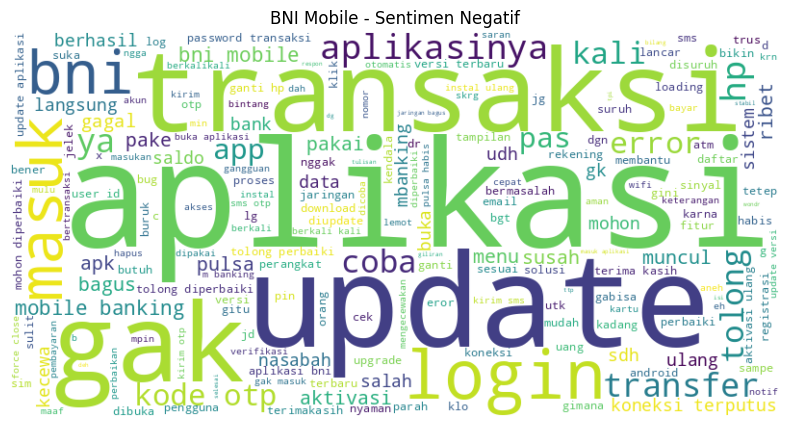

In [18]:
# WordCloud untuk review negatif di BNI Mobile
show_wordcloud(df[(df['app']=='BNI Mobile') & (df['sentiment']=='Negatif')]['text_no_stopwords'], "BNI Mobile - Sentimen Negatif")

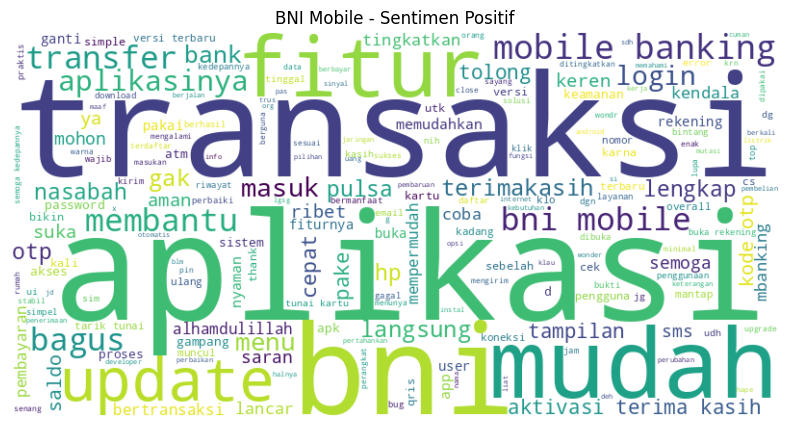

In [19]:
# WordCloud untuk review Positif di BNI Mobile
show_wordcloud(df[(df['app']=='BNI Mobile') & (df['sentiment']=='Positif')]['text_no_stopwords'], "BNI Mobile - Sentimen Positif")

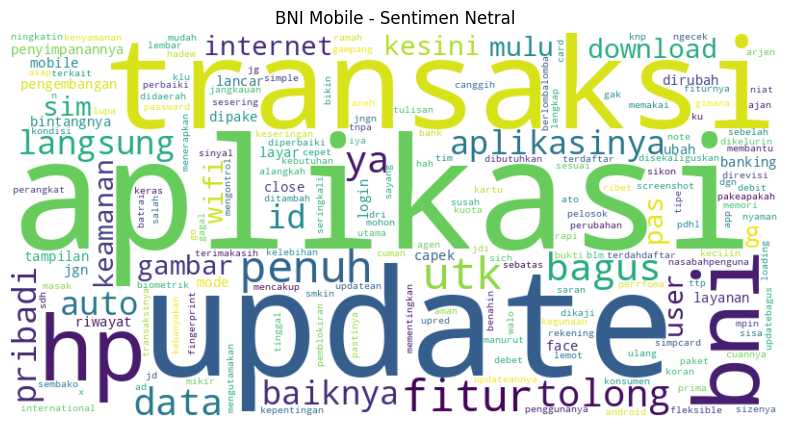

In [20]:
# WordCloud untuk review Netral di BNI Mobile
show_wordcloud(df[(df['app']=='BNI Mobile') & (df['sentiment']=='Netral')]['text_no_stopwords'], "BNI Mobile - Sentimen Netral")